In [1]:
import argparse
import pathlib
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage import io

sys.path.append("../alignment_utils")
from alignment_utils import align_cross_correlation, apply_alignment

# check if in a jupyter notebook
try:
    cfg = get_ipython().config
    in_notebook = True
except NameError:
    in_notebook = False

In [ ]:
if not in_notebook:
    # set up arg parser
    parser = argparse.ArgumentParser(description="Segment the nuclei of a tiff image")
    parser.add_argument(
        "--well_fov",
        type=str,
        help="Well and field of view in the format 'E-11_F000'",
        required=True,
    )
    args = parser.parse_args()
    well_fov = args.well_fov


else:
    well_fov = "E-11_F0004"

final_timepoint_dir = pathlib.Path(
    f"../../2.cellprofiler_ic_processing/illum_directory/timelapse/20231017ChromaLive_6hr_4ch_MaxIP_{well_fov}"
).resolve(strict=True)
terminal_timepoint_dir = pathlib.Path(
    f"../../2.cellprofiler_ic_processing/illum_directory/endpoint/20231017ChromaLive_endpoint_w_AnnexinV_2ch_MaxIP_{well_fov}"
).resolve(strict=True)


offset_file_path = pathlib.Path(
    f"../results/{final_timepoint_dir.stem.split('MaxIP_')[1]}_offsets.parquet"
).resolve()
offset_file_path.parent.mkdir(parents=True, exist_ok=True)

In [3]:
final_timepoint_dna_path = pathlib.Path(
    final_timepoint_dir / f"{well_fov}_T0013_Z0001_C01_illumcorrect.tiff"
).resolve(strict=True)


terminal_timepoint_dna_path = pathlib.Path(
    terminal_timepoint_dir / f"{well_fov}_T0014_Z0001_C01_illumcorrect.tiff"
).resolve(strict=True)

terminal_timepoint_annexin_path = pathlib.Path(
    terminal_timepoint_dir / f"{well_fov}_T0014_Z0001_C05_illumcorrect.tiff"
).resolve(strict=True)

terminal_timepoint_nuclei_mask_path = pathlib.Path(
    terminal_timepoint_dir / f"{well_fov}_T0014_Z0001_nuclei_mask.tiff"
).resolve(strict=True)

terminal_timepoint_cell_mask_path = pathlib.Path(
    terminal_timepoint_dir / f"{well_fov}_T0014_Z0001_cell_mask.tiff"
).resolve(strict=True)

final_timepoint_dna = io.imread(str(final_timepoint_dna_path))
terminal_timepoint_dna = io.imread(str(terminal_timepoint_dna_path))
terminal_timepoint_annexin = io.imread(str(terminal_timepoint_annexin_path))
terminal_timepoint_nuclei_mask = io.imread(str(terminal_timepoint_nuclei_mask_path))
terminal_timepoint_cell_mask = io.imread(str(terminal_timepoint_cell_mask_path))

Align the dna stained images bewteen the two timepoints and apply the same transformation to all terminal images

In [4]:
# get offsets
offsets = align_cross_correlation(
    pixels1=final_timepoint_dna,
    pixels2=terminal_timepoint_dna,
)
print("Offsets: ", offsets)

Offsets:  (38, -73)


/home/lippincm/4TB_A/live_cell_timelapse_apoptosis/5.cellprofiler_analysis/notebooks/../alignment_utils/alignment_utils.py:212: RuntimeWarning: divide by zero encountered in divide
  corrnorm = corr12 / sd
/home/lippincm/4TB_A/live_cell_timelapse_apoptosis/5.cellprofiler_analysis/notebooks/../alignment_utils/alignment_utils.py:212: RuntimeWarning: invalid value encountered in divide
  corrnorm = corr12 / sd


In [5]:
# apply the offsets
aligned_terminal_timepoint_dna = apply_alignment(
    input_image=terminal_timepoint_dna,
    off_x=offsets[0],
    off_y=offsets[1],
    shape=terminal_timepoint_dna.shape,
)
aligned_terminal_timepoint_annexin = apply_alignment(
    input_image=terminal_timepoint_annexin,
    off_x=offsets[0],
    off_y=offsets[1],
    shape=terminal_timepoint_annexin.shape,
)
aligned_terminal_timepoint_nuclei_mask = apply_alignment(
    input_image=terminal_timepoint_nuclei_mask,
    off_x=offsets[0],
    off_y=offsets[1],
    shape=terminal_timepoint_nuclei_mask.shape,
)
aligned_terminal_timepoint_cell_mask = apply_alignment(
    input_image=terminal_timepoint_cell_mask,
    off_x=offsets[0],
    off_y=offsets[1],
    shape=terminal_timepoint_cell_mask.shape,
)

In [6]:
# add offsets to the dataframe
offsets_df = pd.DataFrame(
    {
        "well_fov": [well_fov],
        "x_offset": [offsets[0]],
        "y_offset": [offsets[1]],
    }
)
offsets_df.to_parquet(
    offset_file_path,
    index=False,
)

In [7]:
# save the aligned images
aligned_terminal_timepoint_dna_path = pathlib.Path(
    terminal_timepoint_dir / f"{well_fov}_T0014_Z0001_C01_illumcorrect_aligned.tiff"
).resolve()
aligned_terminal_timepoint_annexin_path = pathlib.Path(
    terminal_timepoint_dir / f"{well_fov}_T0014_Z0001_C05_illumcorrect_aligned.tiff"
).resolve()
aligned_terminal_timepoint_nuclei_mask_path = pathlib.Path(
    terminal_timepoint_dir / f"{well_fov}_T0014_Z0001_nuclei_mask_aligned.tiff"
).resolve()
aligned_terminal_timepoint_cell_mask_path = pathlib.Path(
    terminal_timepoint_dir / f"{well_fov}_T0014_Z0001_cell_mask_aligned.tiff"
).resolve()


io.imsave(str(aligned_terminal_timepoint_dna_path), aligned_terminal_timepoint_dna)
io.imsave(
    str(aligned_terminal_timepoint_annexin_path), aligned_terminal_timepoint_annexin
)
io.imsave(
    str(aligned_terminal_timepoint_nuclei_mask_path),
    aligned_terminal_timepoint_nuclei_mask,
)
io.imsave(
    str(aligned_terminal_timepoint_cell_mask_path), aligned_terminal_timepoint_cell_mask
)

/tmp/ipykernel_584937/2949573886.py:16: UserWarning: /home/lippincm/4TB_A/live_cell_timelapse_apoptosis/2.cellprofiler_ic_processing/illum_directory/endpoint/20231017ChromaLive_endpoint_w_AnnexinV_2ch_MaxIP_E-11_F0004/E-11_F0004_T0014_Z0001_C01_illumcorrect_aligned.tiff is a low contrast image
  io.imsave(str(aligned_terminal_timepoint_dna_path), aligned_terminal_timepoint_dna)
/tmp/ipykernel_584937/2949573886.py:17: UserWarning: /home/lippincm/4TB_A/live_cell_timelapse_apoptosis/2.cellprofiler_ic_processing/illum_directory/endpoint/20231017ChromaLive_endpoint_w_AnnexinV_2ch_MaxIP_E-11_F0004/E-11_F0004_T0014_Z0001_C05_illumcorrect_aligned.tiff is a low contrast image
  io.imsave(
/tmp/ipykernel_584937/2949573886.py:20: UserWarning: /home/lippincm/4TB_A/live_cell_timelapse_apoptosis/2.cellprofiler_ic_processing/illum_directory/endpoint/20231017ChromaLive_endpoint_w_AnnexinV_2ch_MaxIP_E-11_F0004/E-11_F0004_T0014_Z0001_nuclei_mask_aligned.tiff is a low contrast image
  io.imsave(


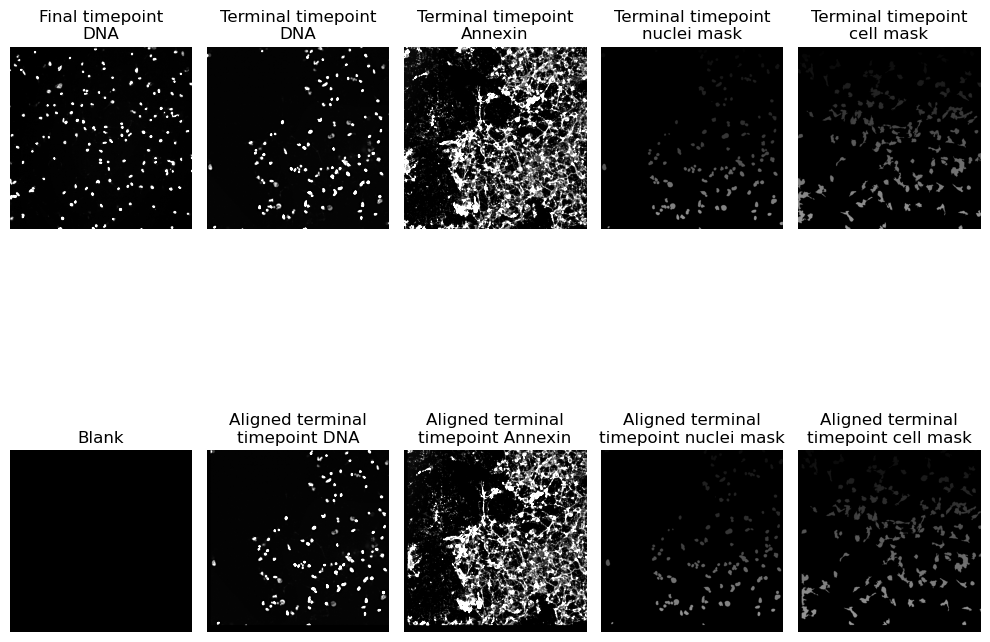

In [8]:
if in_notebook:
    plt.figure(figsize=(10, 10))
    plt.subplot(2, 5, 1)
    plt.imshow(final_timepoint_dna, cmap="gray", vmin=0, vmax=255)
    plt.title("Final timepoint\nDNA")
    plt.axis("off")
    plt.subplot(2, 5, 2)
    plt.imshow(terminal_timepoint_dna, cmap="gray", vmin=0, vmax=255)
    plt.title("Terminal timepoint\nDNA")
    plt.axis("off")
    plt.subplot(2, 5, 3)
    plt.imshow(terminal_timepoint_annexin, cmap="gray", vmin=0, vmax=255)
    plt.title("Terminal timepoint\nAnnexin")
    plt.axis("off")
    plt.subplot(2, 5, 4)
    plt.imshow(terminal_timepoint_nuclei_mask, cmap="gray", vmin=0, vmax=255)
    plt.title("Terminal timepoint\nnuclei mask")
    plt.axis("off")
    plt.subplot(2, 5, 5)
    plt.imshow(terminal_timepoint_cell_mask, cmap="gray", vmin=0, vmax=255)
    plt.title("Terminal timepoint\ncell mask")
    plt.axis("off")
    plt.subplot(2, 5, 6)
    plt.imshow(np.zeros_like(final_timepoint_dna), cmap="gray", vmin=0, vmax=255)
    plt.title("Blank")
    plt.axis("off")
    plt.subplot(2, 5, 7)
    plt.imshow(aligned_terminal_timepoint_dna, cmap="gray", vmin=0, vmax=255)
    plt.title("Aligned terminal\ntimepoint DNA")
    plt.axis("off")
    plt.subplot(2, 5, 8)
    plt.imshow(aligned_terminal_timepoint_annexin, cmap="gray", vmin=0, vmax=255)
    plt.title("Aligned terminal\ntimepoint Annexin")
    plt.axis("off")
    plt.subplot(2, 5, 9)
    plt.imshow(aligned_terminal_timepoint_nuclei_mask, cmap="gray", vmin=0, vmax=255)
    plt.title("Aligned terminal\ntimepoint nuclei mask")
    plt.axis("off")
    plt.subplot(2, 5, 10)
    plt.imshow(aligned_terminal_timepoint_cell_mask, cmap="gray", vmin=0, vmax=255)
    plt.title("Aligned terminal\ntimepoint cell mask")
    plt.axis("off")
    plt.tight_layout()
    plt.show()